In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randn, seed
from scipy.optimize import minimize
import seaborn as sns
import nn_utils

In [2]:
market = pd.read_excel("./Prueba.xlsx",parse_dates=["DATE"],index_col="DATE")
market.columns = [col.replace("MF Equity", "").replace(" INDEX", "").strip() for col in market.columns]
market.head()

,KIMBERA,GAPB,CEMEXCPO,ASURB,GFNORTEO,KOFUBL,AC*,LABB,FEMSAUBD,OMAB,...,MEGACPO,GCC*,BIMBOA,GMEXICOB,GCARSOA1,TLEVICPO,ALFAA,BSMXB,PINFRA*,MEXBOL
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73,42977.50
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93,42113.70
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56,42041.68
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80,41691.19
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75,40661.57


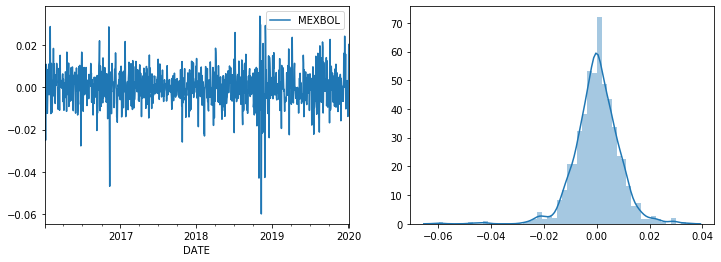

In [3]:
R = market[["MEXBOL"]]
R = np.log(R).diff().dropna()
fig, ax = plt.subplots(1,2,figsize=(12,4))
R.plot(ax=ax[0])
sns.distplot(R, ax=ax[1])


## Modelo de Volatilidad Dinámica
$$ \sigma^2_t = (1-\lambda) r^2_{t-1} + \lambda \sigma^2_{t-1}$$

In [4]:
class DVSigmas:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, lambda_, sigma_init, R):
        self.lambda_ = lambda_
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t-1
        """
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = (1-self.lambda_) * rt0 ** 2 + self.lambda_ * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [5]:
def LDV(lambda_, sigma_init, R):
    s = DVSigmas(lambda_, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum()/2
    return log_likelihood

In [6]:
seed(314)
lambda_ = np.abs(randn(1))
sigma_init = R.var(ddof=1).item()/252
LDV(lambda_,sigma_init,R)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


-551705.0600243221

In [7]:
lambda_

array([0.16608544])

In [8]:
x0 = lambda_
L_part = lambda x0: LDV(x0, sigma_init, R)      

#Restriccion de no negativos
bounds = [
    (0,1)
]

In [9]:
fmin = minimize(L_part,x0, bounds=bounds)
fmin

      fun: -4574577.298184144
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.55879354])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 9
   status: 0
  success: True
        x: array([0.97767149])

In [10]:
lambda_VD = fmin.x
lambda_VD

array([0.97767149])

In [11]:
# Volatilidades sigma2
sigma0 = sigma_init
vd_predict = []
for i in range(len(R)):
    sigma0 = (1-lambda_VD) * R.iloc[i].item()**2 + lambda_VD*sigma0
    vd_predict.append(sigma0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


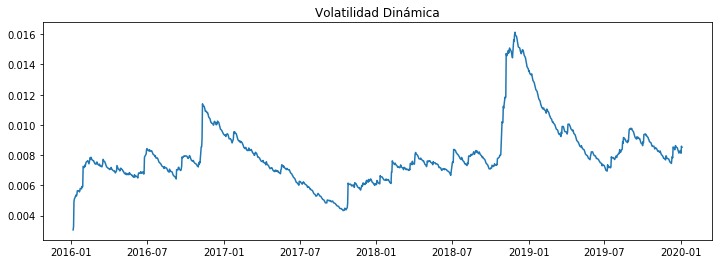

In [12]:
xaxis = R.index[1:]
sigma_vd = np.sqrt(vd_predict)[1:]
plt.subplots(figsize=(12,4))
plt.title("Volatilidad Dinámica")
plt.plot(xaxis, sigma_vd);